# Lisbon MBA Toastmasters enjoy giving feedback to speakers

Toastmasters is a non-profit organisation that provides a space for its members to learn public speaking and leadership skills through deliberate practice and constant feedback about this practice, under a structured development program. The Lisbon MBA Toastmasters Club is a Toastmasters club located in the Nova School of Business and Economics, in Carcavelos, Portugal.

At each Toastmasters meeting, each member can perform one of a multitude of roles that allow them to enhance their leadership and public speaking skills. Meetings at the Lisbon MBA Toastmasters Club take place on Wednesdays, every two weeks.

For this development program to succeed, it is essential for the club to retain a minimum number of members in order to form an encouraging and dynamic learning environment in which members provide feedback to each other during their developmental process. It is therefore essential for the club to provide the conditions for members to remain committed to their learning journey. 

We would like to maximize member retention in the Lisbon MBA Toastmaster Club. For that purpose, I predict when a member is thinking about leaving the club and assess which roles, once taken more frequently by a member, may make more difference between a member staying and leaving the club. These insights may allow the Club Executive Committee to intervene in order to incentivize members to stay, on one hand, and encourage members to take some roles more frequently in order to gain commitment to their skill development, on the other hand. We gathered meeting data from current and past members of the Lisbon MBA Toastmasters Club to predict whether they stayed or left the club through a variety of classification models. The dataset only includes meetings that occurred during the 2022/2023 season. Our dataset is small, so I have built many different classification models in order to capture insights that can be captured across different models.

I have found that:

- ### Members missing more than $40$ days of meetings are probably leaving the club;
- ### Evaluator is the most important role separating members that stay from members that leave;
- ### Speaker and table topic speaker are likely important roles, as expected, but evidence here is inconsistent.

Do members become more commited to their development after taking on these roles? 

Or do they take on these roles ever more frequently after they gain more commitment to their developmental journey?

Perhaps a bit of both, but perhaps the Executive Committee can help members remain committed to their journey.



### I therefore recommend the Club Executive Committee to:
- ### Encourage members to take on the evaluator, the speaker and the table topic speaker roles as soon as possible after joining the club
- ### Engage with members who have been missing more than two Toastmasters meetings in a row. 

In a club that meets twice a month, a member misses meetings for $28$ days by missing two sessions in a row; by missing a third session in a row, the member will be missing over $40$ days of meetings already.

Below I show the classification models that led me to these insights.

## Table of Contents

[Importing members and features](#data)

[Correlation between features](#correlation)

[Modeling churn I: Using Meetings Attended, Last Presence and Joined](#churn1)

[Modeling churn II: Using meeting roles only](#churn2)

[Discussion](#discussion)

## Importing packages

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings('ignore')

## Defining functions

In [2]:
# Plotting a confusion matrix in tones of blue
def plot_confusion_matrix(y,y_predict, title='Confusion Matrix'):
    "this function plots the confusion matrix"

    sns.set(rc={"figure.figsize":(4, 3)})
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, cmap='Blues', annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Reality')
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(['Stayed', 'Left']); ax.yaxis.set_ticklabels(['Stayed', 'Left'])

In [3]:
#A function to define the bar plot colours given a statistical significance, which will be determined through hypothesis testing
#of the permutation importances. In that procedure, the p-value will be the probability that the permutation importance is
#non-positive. Then, a Benjamini-Hochberg multiple comparison procedure is applied.

def barplot_colours(feature_importances):
    '''Calculates p-values (with a Benjamini-Hochberg correction using the number of features) 
    using the permutation importance that make a probability density distribution under the null hypothesis'''
    fi_uncorrected_p = [np.sum(feature_importances[i]<=0)/feature_importances.shape[1] for i in range(feature_importances.shape[0])]
    fi_corrected_p = multipletests(fi_uncorrected_p, method='fdr_bh')
    fi = {'reject': fi_corrected_p[0].tolist(), 'p_value': fi_corrected_p[1].tolist(), 'colour': ['red' if fi_corrected_p[0].tolist()[i] else 'blue' for i in range(feature_importances.shape[0])]} 
    return fi

<a id='data'></a>
## Importing members and features

For each member, we have the following features:
- `Last Presence` - when the last meeting the member has attended took place;
- `Joined` - when the member joined the club;
- `Meetings Attended` - fraction of meetings the member has attended in the 2022/2023 season, i.e. the quotient between the number of meetings attended and the number of meetings that took place during membership.
- `Year Meetings as Member` - the number of meetings that took place in the 2022/2023 season since the member has joined the club.

All remaining features refer to the many different meeting roles. They represent the number of times the member has taken on a given role at a meeting during the 2022/2023 season. The roles under analysis are:
- Toastmaster, `TME` - the meeting's director and host;
- `Speaker` - prepares, rehearses and presents a speech during the club meeting;
- `Evaluator` - provides verbal and written feedback to a meeting speaker;
- Table topics master, `TTM` - delivers the Table Topics portion of the meeting, which helps train members to quickly organize and express their thoughts in an _impromptu_ setting;
- Table topic speaker, `TTS` - delivers an _impromptu_ speech on a topic provided by the table topics master;
- Timekeeper, `TK` - monitors time for each meeting segment and each intervention during the meeting;
- Ah-counter, `AhC` - takes note of all overused words or filler sounds used by other members during their interventions at the meeting;
- Grammarian, `Gr` - introduces new words to meeting participants and monitors the language and grammar usage by all members, noting incomplete sentences, mispronunciations, grammatical mistakes, non-sequiturs, malapropisms, etc;
- General evaluator, `GE` - evaluates everything that takes place during the club meeting.

`Churn` is our response variable, taking a value of $1$ if the member has left the club and $0$ if a member has stayed in the club.

In [4]:
tm_member_info = pd.read_csv('TM members.csv',index_col='Member',decimal=',',
                             usecols=['Member','Joined','Last Presence','TME','GE','TTM','Speaker','Evaluator','TTS','TK','AhC','Gr','Meetings Attended','Year Meetings as Member','Churn'])
tm_member_info.head()

,Joined,TME,GE,TTM,Speaker,Evaluator,TTS,TK,AhC,Gr,Last Presence,Meetings Attended,Year Meetings as Member,Churn
Member,,,,,,,,,,,,,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,23-01-2023,0,0,1,1,0,0,0,1,0,15-05-2023,0.50,14,1
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,22-11-2016,1,1,3,1,1,1,3,1,3,26-07-2023,0.87,23,0
2Z1PQ9200RyXzg9WbTa10S4igYeK,01-04-2022,0,0,1,3,0,3,1,2,0,12-07-2023,0.74,23,0
6TW4zYLA2cnSi8gDvbknHASu3atN,22-03-2022,1,0,1,2,0,4,1,3,2,26-07-2023,0.65,23,0
7a01j1pQcAlB5DVe6pUnwgLhhlY8,11-11-2021,0,0,0,0,0,0,0,0,0,29-06-2022,0.00,23,1


In [5]:
member_fate = tm_member_info['Churn'].value_counts()
fate_mapping = {0:'Stayed', 1:'Left'}
member_fate_mapped = member_fate.rename(index=fate_mapping)

We have fairly balanced dataset on $28$ current and past members of Lisbon MBA Toastmasters, of which $53.6\%$ are still at the club and $46.4\%$ have left the club.

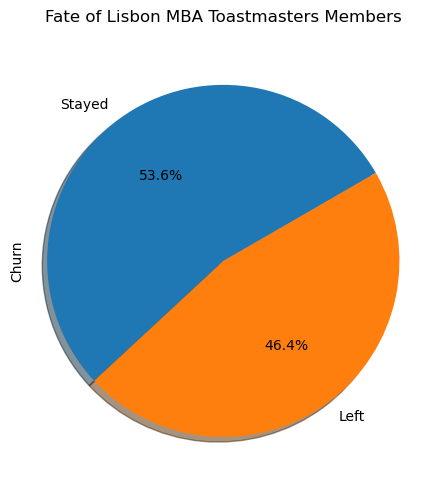

In [6]:
# autopct create %, start angle represent starting point
member_fate_mapped.plot(kind='pie',
                            figsize=(5, 6),
                            startangle=30,     # start angle 90° (Africa)
                            autopct='%1.1f%%', # add in percentages
                            shadow=True,       # add shadow
                            ylabel=None
                            )

plt.title('Fate of Lisbon MBA Toastmasters Members')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

In [7]:
#Converting dates `Last Presence` and `Joined` to the `datetime` type
tm_member_info[['Joined','Last Presence']] = tm_member_info[['Joined','Last Presence']].apply(pd.to_datetime,dayfirst=True)
tm_member_info.head(2)

,Joined,TME,GE,TTM,Speaker,Evaluator,TTS,TK,AhC,Gr,Last Presence,Meetings Attended,Year Meetings as Member,Churn
Member,,,,,,,,,,,,,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,2023-01-23,0,0,1,1,0,0,0,1,0,2023-05-15,0.50,14,1
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,2016-11-22,1,1,3,1,1,1,3,1,3,2023-07-26,0.87,23,0


Converting `Joined` and `Last Presence` to a time difference: we are using the number of days that have passed between the listed date and July $31^{st}$ 2023, the date we will use as a reference. This date closely follows the last meeting of the season.

In [8]:
tm_member_info[['Joined','Last Presence']] = dt.datetime(2023,7,31) - tm_member_info[['Joined','Last Presence']]
tm_member_info.head(2)

,Joined,TME,GE,TTM,Speaker,Evaluator,TTS,TK,AhC,Gr,Last Presence,Meetings Attended,Year Meetings as Member,Churn
Member,,,,,,,,,,,,,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,189 days,0,0,1,1,0,0,0,1,0,77 days,0.50,14,1
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,2442 days,1,1,3,1,1,1,3,1,3,5 days,0.87,23,0


We can see in the table above that _0DUskTCnCDPiF2Ra9je5UiVR2b7W_ has joined the club $189$ days ago and the last time (s)he was at a club session was $77$ days ago, taking July $31^{st}$ 2023 as the reference date. This means that $189$ days have passed from the day this member has joined until July $31^{st}$ 2023 and $77$ days have passed since the last time this member joined a meeting up until July $31^{st}$ 2023.

In [9]:
#Converting dates `Last Presence` and `Joined` to the `timedelta` type
tm_member_info[['Joined','Last Presence']] = tm_member_info[['Joined','Last Presence']].astype('timedelta64[D]')
tm_member_info.head(2)

,Joined,TME,GE,TTM,Speaker,Evaluator,TTS,TK,AhC,Gr,Last Presence,Meetings Attended,Year Meetings as Member,Churn
Member,,,,,,,,,,,,,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,189.0,0,0,1,1,0,0,0,1,0,77.0,0.50,14,1
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,2442.0,1,1,3,1,1,1,3,1,3,5.0,0.87,23,0


The number of roles taken by a member shall be a good indicator of her/his commitment to learning in the club. However, this number is influenced by `Year Meetings as Member`, the number of meetings in the season that took place after the member joined the club. Some people might have taken on less roles simply because they have entered the club in the middle of the season, so they had the chance to attend less meetings. To take this fact into account, I have divided, for each role, the number of times the role was taken, $r$, `Year Meetings as Member`, stated as $m$:

$$ r^{*} = \frac{r}{m} $$

These $r^{*}$ values were the ones used in further analyses.

In [10]:
tm_member_info[['TME','GE','TTM','Speaker','Evaluator','TTS','TK','AhC','Gr']] = tm_member_info[['TME','GE','TTM','Speaker','Evaluator','TTS','TK','AhC','Gr']].apply(lambda x: x/tm_member_info['Year Meetings as Member'])
tm_member_info.head()

,Joined,TME,GE,TTM,Speaker,Evaluator,TTS,TK,AhC,Gr,Last Presence,Meetings Attended,Year Meetings as Member,Churn
Member,,,,,,,,,,,,,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,189.0,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000,77.0,0.50,14,1
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,2442.0,0.043478,0.043478,0.130435,0.043478,0.043478,0.043478,0.130435,0.043478,0.130435,5.0,0.87,23,0
2Z1PQ9200RyXzg9WbTa10S4igYeK,486.0,0.000000,0.000000,0.043478,0.130435,0.000000,0.130435,0.043478,0.086957,0.000000,19.0,0.74,23,0
6TW4zYLA2cnSi8gDvbknHASu3atN,496.0,0.043478,0.000000,0.043478,0.086957,0.000000,0.173913,0.043478,0.130435,0.086957,5.0,0.65,23,0
7a01j1pQcAlB5DVe6pUnwgLhhlY8,627.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,397.0,0.00,23,1


Let's separate the response variable `Churn` in `y` from all other, predictor, features in `X` and generate training and test sets.

In [11]:
y = tm_member_info['Churn'].values
X = tm_member_info[['Joined','Last Presence','TME','GE','TTM','Speaker','Evaluator','TTS','TK','AhC','Gr','Meetings Attended']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=56, stratify=y)

f'{len(X_train)} members in the training set; {len(X_test)} members in the test set'

'19 members in the training set; 9 members in the test set'

<a id='correlation'></a>
## Correlation between features

<Axes: >

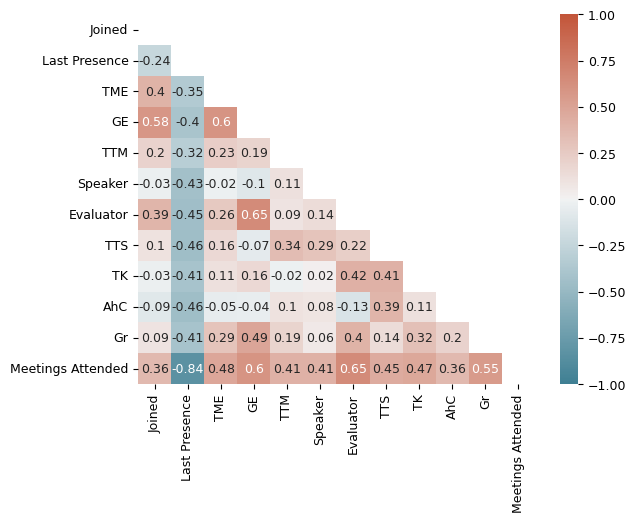

In [12]:
X_feature_corr = X.corr().round(decimals=2)

# Create colour map
# We create a new colour map with the colours
cmap = sns.diverging_palette(220, 20, as_cmap=True)
# We also create a mask matrix in order to plot a triangular matrix only
mask = np.triu(np.ones_like(X_feature_corr, dtype=bool))

plt.rcParams['font.size'] = 9
sns.heatmap(X_feature_corr, annot=True,center=0,vmin=-1,vmax=1,cmap=cmap, mask = mask)

`Last Presence` is strongly correlated with `Meetings Attended` and both of these features are moderately correlated with all meeting roles. On one hand, it seems intuitive that members who have been coming to the most recent meetings have been coming to a higher fraction of meetings. On the other hand, it also seems intuitive that members coming to the most recent meetings and coming to a higher fraction of meetings are more likely to be the members that perform more meeting roles in general.

For these reasons, I have decided to model churn in two separate approaches, using separate feature sets:
 1. Using only `Last Presence`, `Meetings Attended` and `Joined`;
 2. Using only meeting roles.

`Last Presence` and `Meetings Attended` are very strongly correlated, with a correlation of $-0.84$, so information contained in both features is somewhat redundant. Therefore, we should also remove one of these features at the time from our analysis in order to discern the impact of each of these highly correlated features.

Therefore, for the [first approach](#churn1) we will consider three different matrices:
 - `X1`, which will include `Last Presence`, `Meetings Attended` and `Joined`;

In [13]:
X1 = X[['Joined','Last Presence','Meetings Attended']]
X1.head(2)

,Joined,Last Presence,Meetings Attended
Member,,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,189.0,77.0,0.50
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,2442.0,5.0,0.87


 - `X1m`, which will include only `Meetings Attended` and `Joined` (after removing `Last Presence` from `X1`);

In [14]:
X1m = X[['Joined','Meetings Attended']]
X1m.head(2)

,Joined,Meetings Attended
Member,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,189.0,0.50
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,2442.0,0.87


 - `X1p`, which will include only `Last Presence` and `Joined`  (after removing `Meetings Attended` from `X1`).

In [15]:
X1p = X[['Joined','Last Presence']]
X1p.head(2)

,Joined,Last Presence
Member,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,189.0,77.0
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,2442.0,5.0


For the [second approach](#churn2), we define the `X2` matrix, which will only include the meeting roles.

In [16]:
X2 = X.drop(columns=['Joined','Last Presence','Meetings Attended'])
X2.head(2)

,TME,GE,TTM,Speaker,Evaluator,TTS,TK,AhC,Gr
Member,,,,,,,,,
0DUskTCnCDPiF2Ra9je5UiVR2b7W,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000
2MmBWKdDt6Bv7jksDvSZM4SgZ9wJ,0.043478,0.043478,0.130435,0.043478,0.043478,0.043478,0.130435,0.043478,0.130435


<a id='churn1'></a>
## Modelling churn I:
## Using `Meetings Attended`, `Last Presence` and `Joined`

Let's start by splitting our $28$ members into training sets, which will have $70\%$ of the members, and test sets, which will have the remaining $30\%$.

In [17]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.3, random_state=32, stratify=y)
X1m_train, X1m_test, y1m_train, y1m_test = train_test_split(X1m, y, test_size=0.3, random_state=32, stratify=y)
X1p_train, X1p_test, y1p_train, y1p_test = train_test_split(X1p, y, test_size=0.3, random_state=32, stratify=y)

print(len(X1_train),'members in the training set of X1;',len(X1_test),'members in the test set of X1')
print(len(X1m_train),'members in the training set of X1m;',len(X1m_test),'members in the test set of X1m')
print(len(X1p_train),'members in the training set of X1p;',len(X1p_test),'members in the test set of X1p')

19 members in the training set of X1; 9 members in the test set of X1
19 members in the training set of X1m; 9 members in the test set of X1m
19 members in the training set of X1p; 9 members in the test set of X1p


Then we create dataframes to store the accuracy of the different classification models used here initially, gradient boosting and random forest:

- `churnI_jmp_accuracy` to store accuracies of the models including `Last Presence`, `Meetings Attended` and `Joined`;
- `churnI_jm_accuracy` to store accuracies of the models including only `Meetings Attended` and `Joined`;
- `churnI_jp_accuracy` to store accuracies of the models including only `Last Presence`, and `Joined`.

In [18]:
churnI_jmp_accuracy = pd.DataFrame(columns=['Gradient boosting','Random forest'],index=['Training','Testing'])
churnI_jm_accuracy = churnI_jmp_accuracy.copy()
churnI_jp_accuracy = churnI_jmp_accuracy.copy()

Now up to the modeling itself.

### Gradient boosting

In [19]:
lgbm_parameters = {'objective': ['binary'],
                  'boosting_type': ['gbdt'],
                  'n_estimators': [100],
                  'learning_rate': [0.002],
                  'deterministic': [False],
                  'force_col_wise': [True],
                  'max_depth': [1, 2],
                  'colsample_bytree': [0.15, 0.2, 0.25],
                  'min_split_gain': [0.05],
                  'min_child_samples': [7],
                  'min_data_in_bin': [2],
                   'verbose': [-1],
                  }

lgb_jmp = GridSearchCV(lgb.LGBMClassifier(random_state=52), lgbm_parameters, cv=4)
lgb_jmp.fit(X1_train, y1_train)

churnI_jmp_accuracy['Gradient boosting']['Training'] = lgb_jmp.best_score_
churnI_jmp_accuracy['Gradient boosting']['Testing'] = lgb_jmp.score(X1_test,y1_test)

print("Tuned hyperparameters :",lgb_jmp.best_params_)
print("Accuracy on training data:",churnI_jmp_accuracy['Gradient boosting']['Training'])
print("Accuracy on test data:",churnI_jmp_accuracy['Gradient boosting']['Testing'])

Tuned hyperparameters : {'boosting_type': 'gbdt', 'colsample_bytree': 0.15, 'deterministic': False, 'force_col_wise': True, 'learning_rate': 0.002, 'max_depth': 1, 'min_child_samples': 7, 'min_data_in_bin': 2, 'min_split_gain': 0.05, 'n_estimators': 100, 'objective': 'binary', 'verbose': -1}
Accuracy on training data: 1.0
Accuracy on test data: 0.8888888888888888


An $88,9\%$ accuracy in our test data means that the model was only unable to predict correcly the fate of $1$ of the members in the test data, as we can see in the confusion matrix below.

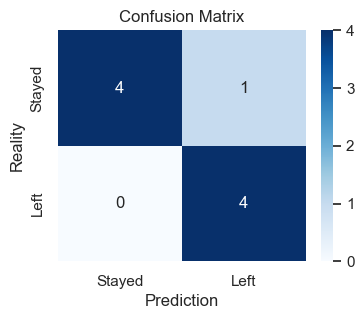

In [20]:
plot_confusion_matrix(y1_test,lgb_jmp.predict(X1_test))

In [21]:
lgb_jmp_fi = permutation_importance(lgb_jmp, X1_train, y1_train,n_repeats=500,scoring='accuracy',random_state=91)
lgb_jmp_fi_p = barplot_colours(lgb_jmp_fi.importances)

### Random forest

In [22]:
#Random state 32
rf_parameters = {'criterion': ['entropy'],
                     'n_estimators': [50], 'min_samples_split': [5, 6, 7],
                     'min_samples_leaf': [3], 'max_depth': [1, 2],
                     'min_impurity_decrease': [0.3], 'max_features': ['sqrt', 'log2']}

In [23]:
rf_jmp = GridSearchCV(
    RandomForestClassifier(random_state=32),
    rf_parameters, cv=4,n_jobs=4)

rf_jmp.fit(X1_train,y1_train)

churnI_jmp_accuracy['Random forest']['Training'] = rf_jmp.best_score_
churnI_jmp_accuracy['Random forest']['Testing'] = rf_jmp.score(X1_test,y1_test)

print("Tuned hyperparameters :",rf_jmp.best_params_)
print("Accuracy in training data:",churnI_jmp_accuracy['Random forest']['Training'])
print("Accuracy in test data: ", churnI_jmp_accuracy['Random forest']['Testing'])

Tuned hyperparameters : {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_impurity_decrease': 0.3, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy in training data: 1.0
Accuracy in test data:  0.8888888888888888


In [24]:
rf_jmp_fi = permutation_importance(rf_jmp, X1_train, y1_train,n_repeats=500,scoring='accuracy',random_state=91)
rf_jmp_fi_p = barplot_colours(rf_jmp_fi.importances)

In [25]:
churnI_jmp_accuracy

,Gradient boosting,Random forest
Training,1.0,1.0
Testing,0.888889,0.888889


Both models have the same, very high accuracy, both in training and testing datasets.

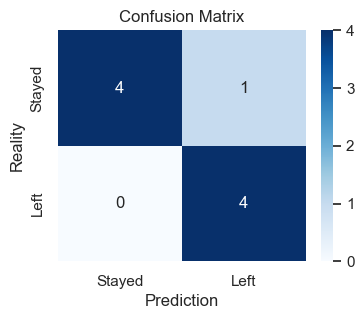

In [26]:
plot_confusion_matrix(y1_test,rf_jmp.predict(X1_test))

Text(0.5, 1.0, 'Random Forest')

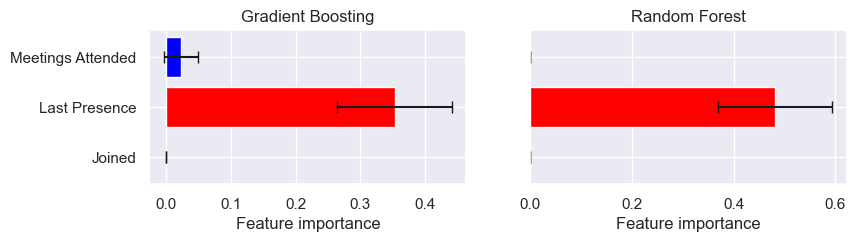

In [27]:
fig, ax = plt.subplots(1,2,figsize=(9,2),sharey=True)

ax[0].barh(X1.columns,lgb_jmp_fi.importances_mean,xerr=lgb_jmp_fi.importances_std, capsize=4,color=lgb_jmp_fi_p['colour'])
ax[0].set_xlabel('Feature importance')
ax[0].set_title('Gradient Boosting')

ax[1].barh(X1.columns,rf_jmp_fi.importances_mean,xerr=rf_jmp_fi.importances_std, capsize=4,color=rf_jmp_fi_p['colour'])
ax[1].set_xlabel('Feature importance')
ax[1].set_ylabel(None)
ax[1].set_title('Random Forest')

`Last Presence` is the most important feature among these three separating members staying from members leaving. <font color='red'> The red bar indicates that this importance is statistically significant. </a>

## Using `Meetings Attended` and `Joined`
Given that `Meetings Attended` and `Last Presence` are highly correlated, as we have seen [above](#correlation), I am repeating the analysis by removing `Last Presence` to check how multicollinearity might influence the result we have just seen.

### Gradient boosting

In [28]:
lgbm_parameters = {'objective': ['binary'],
                  'boosting_type': ['gbdt'],
                  'n_estimators': [100],
                  'learning_rate': [0.0015],
                  'deterministic': [False],
                  'force_col_wise': [True],
                  'max_depth': [1, 2],
                  'colsample_bytree': [0.2, 0.25, 0.3],
                  'min_split_gain': [0.5],
                  'min_child_samples': [6],
                  'min_data_in_bin': [5],
                   'verbose': [-1]
                  }

lgb_jm = GridSearchCV(lgb.LGBMClassifier(random_state=22), lgbm_parameters, cv=4)
lgb_jm.fit(X1m_train, y1m_train)

churnI_jm_accuracy['Gradient boosting']['Training'] = lgb_jm.best_score_
churnI_jm_accuracy['Gradient boosting']['Testing'] = lgb_jm.score(X1m_test,y1m_test)

print("Tuned hyperparameters :",lgb_jm.best_params_)
print("Accuracy on training data:",churnI_jm_accuracy['Gradient boosting']['Training'])
print("Accuracy on test data:",churnI_jm_accuracy['Gradient boosting']['Testing'])

Tuned hyperparameters : {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'deterministic': False, 'force_col_wise': True, 'learning_rate': 0.0015, 'max_depth': 1, 'min_child_samples': 6, 'min_data_in_bin': 5, 'min_split_gain': 0.5, 'n_estimators': 100, 'objective': 'binary', 'verbose': -1}
Accuracy on training data: 0.95
Accuracy on test data: 0.8888888888888888


We can still obtain a very accurate model without `Last Presence`.

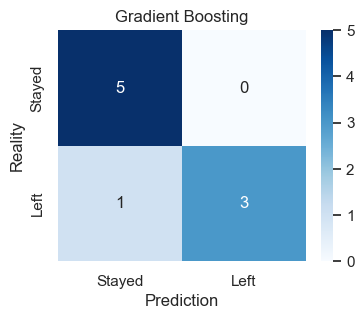

In [29]:
plot_confusion_matrix(y1m_test,lgb_jm.predict(X1m_test),title='Gradient Boosting')

In [30]:
lgb_jm_fi = permutation_importance(lgb_jm, X1m_train, y1m_train, n_repeats=500,scoring='accuracy',random_state=91)
lgb_jm_fi_p = barplot_colours(lgb_jm_fi.importances)

### Random forest

In [31]:
rf_parameters = {'criterion': ['entropy'],
                     'n_estimators': [50], 'min_samples_split': [8],
                     'min_samples_leaf': [2], 'max_depth': [1],
                     'min_impurity_decrease': [0.05, 0.1, 0.2, 0.3, 0.4],'ccp_alpha':[0, 0.1], 'max_features': ['sqrt']}

In [32]:
rf_jm = GridSearchCV(
    RandomForestClassifier(random_state=67),
    rf_parameters, cv=4,n_jobs=4)

rf_jm.fit(X1m_train,y1m_train)

churnI_jm_accuracy['Random forest']['Training'] = rf_jm.best_score_
churnI_jm_accuracy['Random forest']['Testing'] = rf_jm.score(X1m_test,y1m_test)

print("Tuned hyperparameters :",rf_jm.best_params_)
print("Accuracy on training data:",churnI_jm_accuracy['Random forest']['Training'])
print("Accuracy on test data: ", churnI_jm_accuracy['Random forest']['Testing'])

Tuned hyperparameters : {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_impurity_decrease': 0.05, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 50}
Accuracy on training data: 0.95
Accuracy on test data:  0.8888888888888888


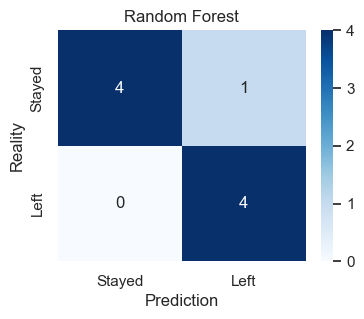

In [33]:
plot_confusion_matrix(y1m_test,rf_jm.predict(X1m_test),title='Random Forest')

In [34]:
rf_jm_fi = permutation_importance(rf_jm, X1m_train, y1m_train,n_repeats=500,scoring='accuracy',random_state=91)
rf_jm_fi_p = barplot_colours(rf_jm_fi.importances)

In [35]:
churnI_jm_accuracy

,Gradient boosting,Random forest
Training,0.95,0.95
Testing,0.888889,0.888889


Both models are equally accurate, and still very accurate, without `Last Presence`.

Text(0.5, 1.0, 'Random Forest')

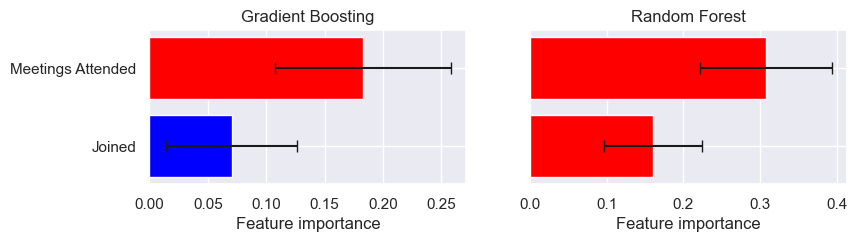

In [36]:
fig, ax = plt.subplots(1,2,figsize=(9,2),sharey=True)

ax[0].barh(X1m.columns,lgb_jm_fi.importances_mean,xerr=lgb_jm_fi.importances_std,capsize=4,color=lgb_jm_fi_p['colour'])
ax[0].set_xlabel('Feature importance')
ax[0].set_title('Gradient Boosting')

ax[1].barh(X1m.columns,rf_jm_fi.importances_mean,xerr=rf_jm_fi.importances_std,capsize=4,color=rf_jm_fi_p['colour'])
ax[1].set_xlabel('Feature importance')
ax[1].set_title('Random Forest')

Without `Last Presence`, `Meetings Attended` is, unsurprisingly, the most important feature in predicting member churn.
<font color='red'> Red bars indicate the importances that are statistically significant. </a>

`Joined`, how long ago the member has joined the club, shows up as statistically significant in the random forest model.

## Using `Last Presence` and `Joined`

I am now substituting `Last Presence` for `Meetings Attended` to check how multicollinearity might influence the result we have first seen, in which both features were included. This analysis, alongside the previous one, shall bring us insight regarding the most impactful feature in predicting churn between these very correlated features.

### Gradient boosting

In [37]:
lgbm_parameters = {'objective': ['binary'],
                  'boosting_type': ['gbdt'],
                  'n_estimators': [50],
                  'learning_rate': [0.1],
                  'deterministic': [False],
                  'force_col_wise': [True],
                  'max_depth': [1, 2],
                  'colsample_bytree': [0.2, 0.3, 1/3],
                  'min_split_gain': [0.5, 0.6],
                  'min_child_samples': [3, 4, 5],
                  'min_data_in_bin': [2, 3, 4],
                   'verbose': [-1]
                  }

lgb_jp = GridSearchCV(lgb.LGBMClassifier(random_state=32), lgbm_parameters, cv=4)
lgb_jp.fit(X1p_train, y1p_train)

churnI_jp_accuracy['Gradient boosting']['Training'] = lgb_jp.best_score_
churnI_jp_accuracy['Gradient boosting']['Testing'] = lgb_jp.score(X1p_test,y1p_test)

print("Tuned hyperparameters :",lgb_jp.best_params_)
print("Accuracy on training data:",churnI_jp_accuracy['Gradient boosting']['Training'])
print("Accuracy on test data:",churnI_jp_accuracy['Gradient boosting']['Testing'])

Tuned hyperparameters : {'boosting_type': 'gbdt', 'colsample_bytree': 0.2, 'deterministic': False, 'force_col_wise': True, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_samples': 5, 'min_data_in_bin': 2, 'min_split_gain': 0.5, 'n_estimators': 50, 'objective': 'binary', 'verbose': -1}
Accuracy on training data: 0.95
Accuracy on test data: 0.8888888888888888


We again see a very accurate model, this time without `Meetings Attended`.

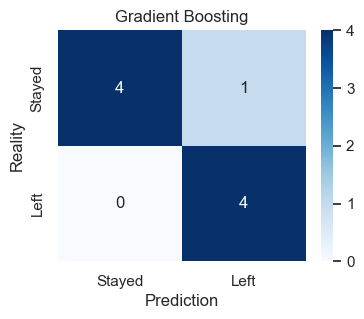

In [38]:
plot_confusion_matrix(y1p_test,lgb_jp.predict(X1p_test),title='Gradient Boosting')

In [39]:
lgb_jp_fi = permutation_importance(lgb_jp, X1p_train, y1p_train,n_repeats=500,scoring='accuracy',random_state=91)
lgb_jp_fi_p = barplot_colours(lgb_jp_fi.importances)

### Random forest

In [40]:
#Random state 32
rf_parameters = {'criterion': ['entropy'],
                     'n_estimators': [50], 'min_samples_split': [5, 6, 7],
                     'min_samples_leaf': [3, 4, 5], 'max_depth': [1, 2, 3],
                     'min_impurity_decrease': [0.05, 0.1, 0.2], 'max_features': ['sqrt', 'log2']}

rf_jp = GridSearchCV(
    RandomForestClassifier(random_state=32),
    rf_parameters, cv=4,n_jobs=4)

rf_jp.fit(X1p_train,y1p_train)

churnI_jp_accuracy['Random forest']['Training'] = rf_jp.best_score_
churnI_jp_accuracy['Random forest']['Testing'] = rf_jp.score(X1p_test,y1p_test)

print("Tuned hyperparameters :",rf_jp.best_params_)
print("Accuracy on training data:",rf_jp.best_score_)
print("Accuracy on test data: ", rf_jp.score(X1p_test,y1p_test))

Tuned hyperparameters : {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_impurity_decrease': 0.05, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy on training data: 0.95
Accuracy on test data:  0.8888888888888888


Again a very accurate model both in train and test data.

In [41]:
rf_jp_fi = permutation_importance(rf_jp, X1p_train, y1p_train,n_repeats=500,scoring='accuracy',random_state=91)
rf_jp_fi_p = barplot_colours(rf_jp_fi.importances)

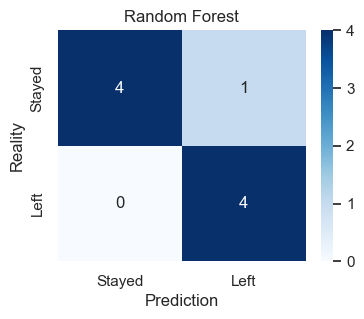

In [42]:
plot_confusion_matrix(y1p_test,rf_jp.predict(X1p_test),title='Random Forest')

In [43]:
churnI_jp_accuracy

,Gradient boosting,Random forest
Training,0.95,0.95
Testing,0.888889,0.888889


Both models are equally accurate, and still very accurate, without `Meetings Attended`.

Text(0.5, 1.0, 'Random Forest')

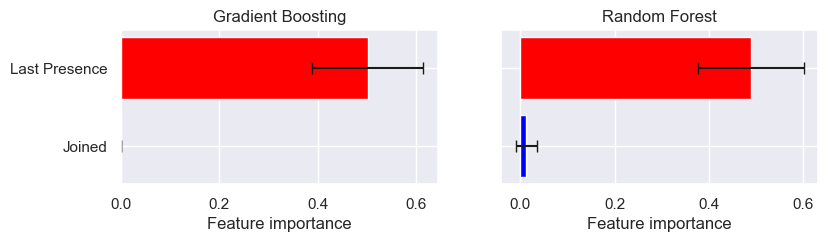

In [44]:
fig, ax = plt.subplots(1,2,figsize=(9,2),sharey=True)

ax[0].barh(X1p.columns,lgb_jp_fi.importances_mean,xerr=lgb_jp_fi.importances_std, capsize=4,color=lgb_jp_fi_p['colour'])
ax[0].set_xlabel('Feature importance')
ax[0].set_title('Gradient Boosting')

ax[1].barh(X1p.columns,rf_jp_fi.importances_mean,xerr=rf_jp_fi.importances_std, capsize=4,color=rf_jp_fi_p['colour'])
ax[1].set_xlabel('Feature importance')
ax[1].set_title('Random Forest')

In both models `Last Presence` is the only important feature. We can also see that when `Last Presence` is in the analysis, the importance of `Joined` goes down to a flat zero. This result is consistent with the importances seen when the three features were included.

From this first part of the churn prediction, it is clear that the most important feature we can use to predict whether a member will stay or leave the club is `Last Presence`, how long ago was the last time the member was present at a meeting. Although this is very correlated with `Meetings Attended`, the fraction of meetings the member has attended, the hiatus since the last meeting clearly holds a major importance.

The importance of `Last Presence` is not surprising at all for us who are Toastmasters. It might be surprising though, that this hiatus since the last presence at a meeting is even more important than the fraction of meetings attended as a member.

### Decision trees

Decision trees can give us a more direct interpretation regarding what distinguishes members that stay in the club from members that leave. We here build a decision tree model using the `X1` matrix.

In [45]:
decision_tree1_parameters = {'criterion':['entropy'],
                             'max_depth': [1],
                             'max_features': [1],
                             'min_samples_leaf': [6],
                             'min_samples_split': [10]}

dt_cv = GridSearchCV(DecisionTreeClassifier(random_state=18), decision_tree1_parameters, cv=4,scoring='accuracy')
dt_cv.fit(X1_train,y1_train)
print("Tuned hyperparameters :",dt_cv.best_params_)
print("Accuracy on training data :",dt_cv.best_score_)
print("Accuracy on test data: ", dt_cv.score(X1_test,y1_test))

Tuned hyperparameters : {'criterion': 'entropy', 'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 6, 'min_samples_split': 10}
Accuracy on training data : 1.0
Accuracy on test data:  0.8888888888888888


The accuracy of this decision tree model is $88.9\%$ in the test data. We only have one false positive in our predictions, i.e., one member we predicted to leave but stayed.

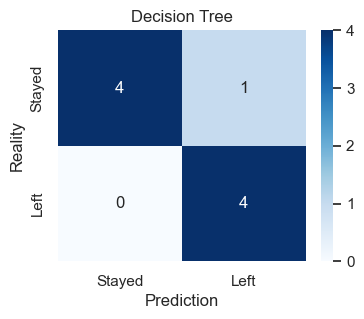

In [46]:
churn_prediction_dt1 = dt_cv.predict(X1_test)
plot_confusion_matrix(y1_test,churn_prediction_dt1,title='Decision Tree')

In [47]:
dt2_cv = GridSearchCV(DecisionTreeClassifier(random_state=21), decision_tree1_parameters, cv=4,scoring='accuracy')
dt2_cv.fit(X1p_train,y1p_train)
print("Tuned hyperparameters :",dt2_cv.best_params_)
print("Accuracy on training data:",dt2_cv.best_score_)
print("Accuracy on test data: ", dt2_cv.score(X1p_test,y1p_test))

Tuned hyperparameters : {'criterion': 'entropy', 'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 6, 'min_samples_split': 10}
Accuracy on training data: 1.0
Accuracy on test data:  0.8888888888888888


A decision tree model excluding `Meetings Attended` has the exact same accuracy.

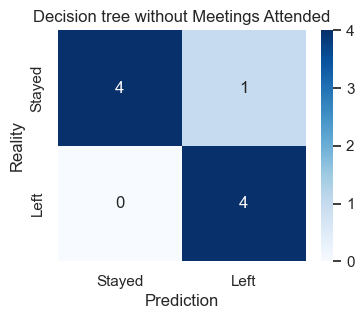

In [48]:
churn_prediction_dt2 = dt2_cv.predict(X1p_test)
plot_confusion_matrix(y1p_test,churn_prediction_dt2,title='Decision tree without Meetings Attended')

Text(0.5, 1.0, 'Excluding Meetings Attended')

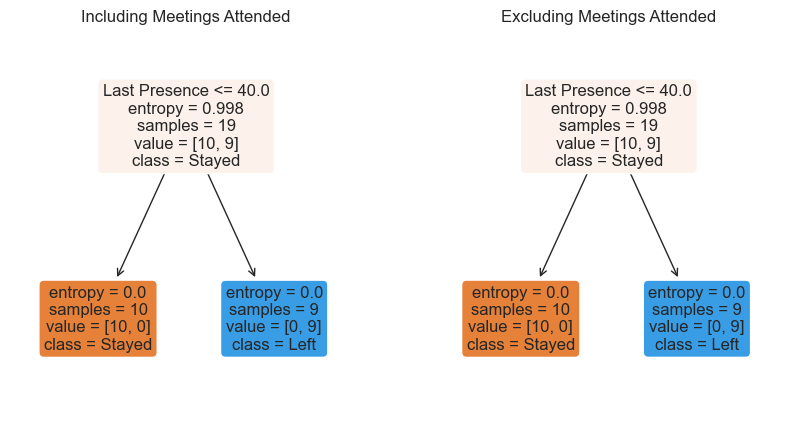

In [49]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

plot_tree(dt_cv.best_estimator_,feature_names = X1.columns,class_names = ['Stayed','Left'],filled=True,rounded=True, ax=ax[0])
ax[0].set_title('Including Meetings Attended')

plot_tree(dt2_cv.best_estimator_,feature_names = X1p.columns,class_names = ['Stayed','Left'],filled=True,rounded=True, ax=ax[1])
ax[1].set_title('Excluding Meetings Attended')

The decision trees above show that members who have been missing meetings for more than $40$ days have left the club. The remaining members stay in the club. We see again that `Last Presence` is the most important feature separating members who stay from members who leave the club. This result is very consistent with what we have seen both in the gradient boosting and in the random forest models.  

The decision criterium and accuracy are the same regardless of whether or not `Meetings Attended` is included in the model.

So far, gradient boosting, random forests and decision trees using `Last Presence`, `Meetings Attended` and `Joined` accurately separate members staying from members leaving and show consistently that `Last Presence`, the time passed since their last visit, is the most important feature separating members staying from members leaving. 

### The decision tree model shows that members missing more than the latest $40$ days of meetings have left the club and the remainder stay at the club.

However, I still believe I can gather even more valuable information with the dataset we have. Let's now look at the features regarding meeting roles.

<a id='churn2'></a>
## Modelling churn II: Using meeting roles only

I would like to dig deeper to see if we can obtain more valuable and less intuitive information that distinguishes members who stay from members who leave the club. 

For that purpose, my aim is to use classification models, using the meeting roles instead. I also will explore two extra classification models, the support vector machine and k-nearest neighbours models. 

We start here by splitting the meeting role matrix `X2` into a train and a test set.

In [50]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.3, random_state=32, stratify=y)
print(len(X2_train),'members in the training set')
print(len(X2_test),'members in the test set')

19 members in the training set
9 members in the test set


In [51]:
churnII_accuracy = pd.DataFrame(columns=['Gradient boosting','Random forest','Support vector machine','K-nearest neighbours','Decision tree'],index=['Training','Testing'])

### Gradient boosting

In [52]:
lgbm2_parameters = {'objective': ['binary'],
                  'boosting_type': ['gbdt'],
                  'n_estimators': [20, 50],
                  'learning_rate': [0.006],
                  'deterministic': [False],
                  'force_col_wise': [True],
                  'max_depth': [1, 2],
                  'colsample_bytree': [0.3, 0.4],
                  'min_split_gain': [3],
                  'min_child_samples': [3, 4, 5],
                   'min_data_in_bin': [5, 6, 7],
                    'verbose':[-1]
                  }

lgb2_cv = GridSearchCV(lgb.LGBMClassifier(random_state=32), lgbm2_parameters, cv=4)
lgb2_cv.fit(X2_train, y2_train)

churnII_accuracy['Gradient boosting']['Training'] = lgb2_cv.best_score_
churnII_accuracy['Gradient boosting']['Testing'] = lgb2_cv.score(X2_test,y2_test)

print("Tuned hyperparameters :",lgb2_cv.best_params_)
print("Accuracy on training data:",churnII_accuracy['Gradient boosting']['Training'])
print("Accuracy on test data:",churnII_accuracy['Gradient boosting']['Testing'])

Tuned hyperparameters : {'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'deterministic': False, 'force_col_wise': True, 'learning_rate': 0.006, 'max_depth': 1, 'min_child_samples': 3, 'min_data_in_bin': 5, 'min_split_gain': 3, 'n_estimators': 50, 'objective': 'binary', 'verbose': -1}
Accuracy on training data: 0.9
Accuracy on test data: 0.8888888888888888


The gradient boosting model is highly accurate, with $90\%$ accuracy in the training data and $88.9\%$ accuracy in the test data.

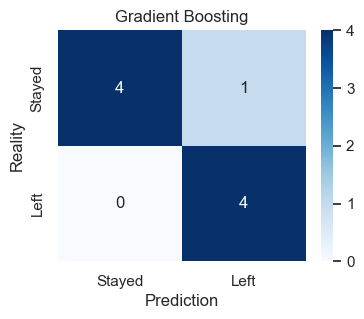

In [53]:
churn_prediction_gb2 = lgb2_cv.predict(X2_test)
plot_confusion_matrix(y2_test,churn_prediction_gb2,title='Gradient Boosting')

In [54]:
lgb2_cv_fi = permutation_importance(lgb2_cv, X2_train, y2_train,n_repeats=500,scoring='accuracy',random_state=91)
lgb2_cv_fi_p = barplot_colours(lgb2_cv_fi.importances)

### Random forest

In [55]:
rf2_parameters = {'criterion': ['entropy'],
                  'n_estimators': [100], 'min_samples_split': [5],
                  'min_samples_leaf': [3],
                  'min_impurity_decrease': [0.2], 'max_features': [1, 2], 'ccp_alpha':[0.15]}

In [56]:
rf2_cv = GridSearchCV(
    RandomForestClassifier(random_state=35),
    rf2_parameters, cv=4,n_jobs=4)
rf2_cv.fit(X2_train,y2_train)

churnII_accuracy['Random forest']['Training'] = rf2_cv.best_score_
churnII_accuracy['Random forest']['Testing'] = rf2_cv.score(X2_test,y2_test)

print("Tuned hyperparameters :",rf2_cv.best_params_)
print("Accuracy on training data :",churnII_accuracy['Random forest']['Training'])
print("Accuracy on test data:",churnII_accuracy['Random forest']['Testing'])

Tuned hyperparameters : {'ccp_alpha': 0.15, 'criterion': 'entropy', 'max_features': 2, 'min_impurity_decrease': 0.2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy on training data : 0.85
Accuracy on test data: 0.7777777777777778


The random forest model here is less accurate than the gradient boosting model, with $85\%$ accuracy in the training data and $78\%$ in our test data.

In [57]:
rf2_cv_fi = permutation_importance(rf2_cv, X2_train, y2_train,n_repeats=2000,scoring='accuracy',random_state=91)
rf2_cv_fi_p = barplot_colours(rf2_cv_fi.importances)

### Support vector machine

In [58]:
svm_parameters = {'loss': ['hinge','squared_hinge'],
                  'penalty':['l2'],'dual':[False], 'C':[0.26], 'tol':[1e-8],
                  'max_iter':[100]}

In [59]:
svm_cv = GridSearchCV(
    LinearSVC(random_state=1),
    svm_parameters, cv=4,n_jobs=4)
svm_cv.fit(X2_train,y2_train)

churnII_accuracy['Support vector machine']['Training'] = svm_cv.best_score_
churnII_accuracy['Support vector machine']['Testing'] = svm_cv.score(X2_test,y2_test)

print("Tuned hyperparameters :",svm_cv.best_params_)
print("Accuracy on training data :",churnII_accuracy['Support vector machine']['Training'])
print("Accuracy on test data:",churnII_accuracy['Support vector machine']['Testing'])

Tuned hyperparameters : {'C': 0.26, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 100, 'penalty': 'l2', 'tol': 1e-08}
Accuracy on training data : 0.7875
Accuracy on test data: 0.7777777777777778


The support vector machine model is also less accurate than the gradient boosting model.

In [60]:
svm_cv_fi = permutation_importance(svm_cv, X2_train, y2_train,n_repeats=2000,scoring='accuracy',random_state=91)
svm_cv_fi_p = barplot_colours(svm_cv_fi.importances)

### K-nearest neighbours

In [61]:
Scaler = StandardScaler()
X2_train_transformed = Scaler.fit_transform(X2_train)
X2_test_transformed = Scaler.transform(X2_test)

In [62]:
knn_parameters = {'n_neighbors': [6]}

knn_cv = GridSearchCV(
    KNeighborsClassifier(),knn_parameters,cv=4)
knn_cv.fit(X2_train_transformed,y2_train)

churnII_accuracy['K-nearest neighbours']['Training'] = knn_cv.best_score_
churnII_accuracy['K-nearest neighbours']['Testing'] = knn_cv.score(X2_test_transformed,y2_test)

print("Tuned hyperparameters :",knn_cv.best_params_)
print("Accuracy on training data:",churnII_accuracy['K-nearest neighbours']['Training'])
print("Accuracy on test data:",churnII_accuracy['K-nearest neighbours']['Testing'])

Tuned hyperparameters : {'n_neighbors': 6}
Accuracy on training data: 0.825
Accuracy on test data: 0.7777777777777778


The k-nearest neighbours model is also less accurate than the gradient boosting model.

In [63]:
knn_cv_fi = permutation_importance(knn_cv, X2_train_transformed, y2_train,n_repeats=2000,scoring='accuracy',random_state=91)
knn_cv_fi_p = barplot_colours(knn_cv_fi.importances)

### Decision tree

In [64]:
decision_tree2_parameters = {'criterion':['entropy'],
                             'max_features': [2, 3, 4, 5],
                             'max_depth': [1, 2, 3],
                             'min_samples_leaf': [2, 3, 4],
                             'min_samples_split': [5, 6, 7, 8],
                             'min_impurity_decrease': [0, 0.3, 0.5],
                             'ccp_alpha': [0, 0.1, 0.2]}

dt3_cv = GridSearchCV(DecisionTreeClassifier(random_state=1), decision_tree2_parameters, cv=4,scoring='accuracy')
dt3_cv.fit(X2_train,y2_train)

churnII_accuracy['Decision tree']['Training'] = dt3_cv.best_score_
churnII_accuracy['Decision tree']['Testing'] = dt3_cv.score(X2_test,y2_test)

print("Tuned hyperparameters :",dt3_cv.best_params_)
print("Accuracy on training data :",churnII_accuracy['Decision tree']['Training'])
print("Accuracy on test data: ", churnII_accuracy['Decision tree']['Testing'])

Tuned hyperparameters : {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 5, 'min_impurity_decrease': 0, 'min_samples_leaf': 2, 'min_samples_split': 8}
Accuracy on training data : 0.9
Accuracy on test data:  0.8888888888888888


With an accuracy of $90\%$ in the train set and $88.9\%$ for the test set, this decision tree model is the only model with an accuracy that is comparable to the one found in the gradient boosting model.

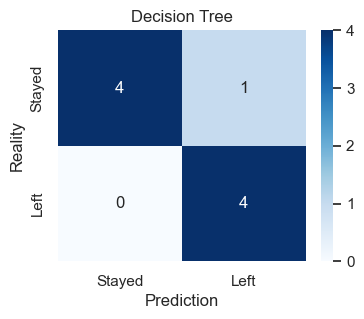

In [65]:
churn_prediction_dt3 = dt3_cv.predict(X2_test)
plot_confusion_matrix(y2_test,churn_prediction_dt3,title='Decision Tree')

<a id='decision_tree_churn2'></a>

[Text(0.6, 0.8333333333333334, 'Evaluator <= 0.022\nentropy = 0.998\nsamples = 19\nvalue = [10, 9]\nclass = Stayed'),
 Text(0.4, 0.5, 'Speaker <= 0.079\nentropy = 0.684\nsamples = 11\nvalue = [2, 9]\nclass = Left'),
 Text(0.2, 0.16666666666666666, 'entropy = 0.0\nsamples = 9\nvalue = [0, 9]\nclass = Left'),
 Text(0.6, 0.16666666666666666, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = Stayed'),
 Text(0.8, 0.5, 'entropy = 0.0\nsamples = 8\nvalue = [8, 0]\nclass = Stayed')]

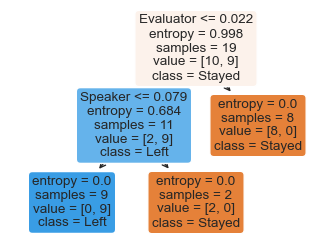

In [66]:
plot_tree(dt3_cv.best_estimator_,feature_names = X2.columns, class_names = ['Stayed','Left'],filled=True,rounded=True)

In the decision tree model, the evaluator role separates most of the members who leave from those who remain in the club. The speaker role separates the remaining members who stay.
It is very interesting to realize that the threshold value for the evaluator role is $0.022$. This is equivalent to taking the evaluator role once every $45$ meetings!

In [67]:
1/0.022

45.45454545454546

This means that in general a member that takes on the evaluator role once is very likely to be very committed to his development at the club and remain at the club.

On the other hand, the threshold for the speaker role is $0.079$, which is equivalent to deliver a prepared speech every $12$ meetings at least!

In [68]:
1/0.079

12.658227848101266

This season has had $22$ meetings, so these values illustrate how important these roles seem to be in separating in the decision tree model the members who have stayed from members who have left.

In [69]:
dt3_cv_fi = permutation_importance(dt3_cv, X2_train_transformed, y2_train, n_repeats=500, scoring='accuracy',random_state=91)
dt3_cv_fi_p = barplot_colours(dt3_cv_fi.importances)

### Feature importances in all models

The most accurate models we have using meeting roles are the gradient boosting and the decision tree.

In [70]:
churnII_accuracy

,Gradient boosting,Random forest,Support vector machine,K-nearest neighbours,Decision tree
Training,0.9,0.85,0.7875,0.825,0.9
Testing,0.888889,0.777778,0.777778,0.777778,0.888889


In both of those models, we can see that the evaluator role holds major importance in separating members who stay at the club from members who leave. The evaluator role is, in fact, the only role whose importance is <font color = 'red'> statistically significant </a> .

Text(0.5, 1.0, 'Decision Tree')

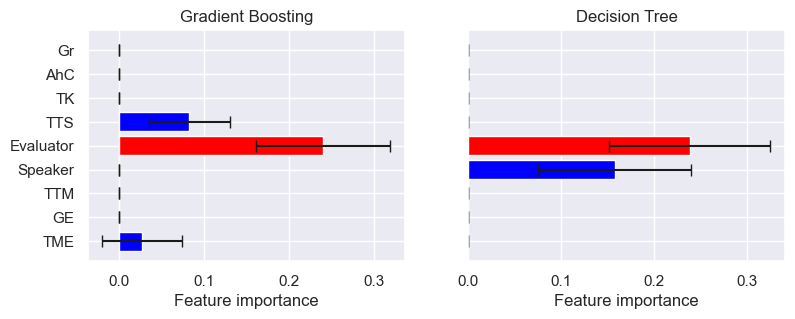

In [71]:
fig, ax = plt.subplots(1,2,figsize=(9,3),sharey=True)

ax[0].barh(X2.columns,lgb2_cv_fi.importances_mean,xerr=lgb2_cv_fi.importances_std, capsize=4, color=lgb2_cv_fi_p['colour'])
ax[0].set_xlabel('Feature importance')
ax[0].set_title('Gradient Boosting')

ax[1].barh(X2.columns,dt3_cv_fi.importances_mean, xerr=dt3_cv_fi.importances_std, capsize=4,color=dt3_cv_fi_p['colour'])
ax[1].set_xlabel('Feature importance')
ax[1].set_title('Decision Tree')

According to the gradient boosting model, the table topic speaker `TTS` role seems to hold importance, but we have no statistical significance there. The same happens in the decision tree model, in which the speaker role seems to hold importance, but we find no statistical significance. This observation in the decision tree model is consistent with the [decision tree](#decision_tree_churn2) .

Text(0.5, 1.0, 'K-nearest neighbours')

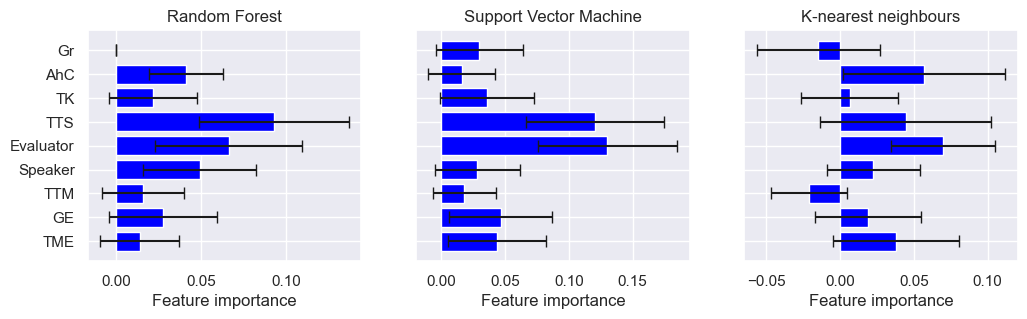

In [72]:
fig, ax = plt.subplots(1,3,figsize=(12,3),sharey=True)
ax[0].barh(X2.columns,rf2_cv_fi.importances_mean,xerr=rf2_cv_fi.importances_std, capsize=4, color=rf2_cv_fi_p['colour'])
ax[0].set_xlabel('Feature importance')
ax[0].set_title('Random Forest')

ax[1].barh(X2.columns,svm_cv_fi.importances_mean,xerr=svm_cv_fi.importances_std,capsize=4, color=svm_cv_fi_p['colour'])
ax[1].set_xlabel('Feature importance')
ax[1].set_title('Support Vector Machine')

ax[2].barh(X2.columns,knn_cv_fi.importances_mean,xerr=knn_cv_fi.importances_std, capsize=4, color=knn_cv_fi_p['colour'])
ax[2].set_xlabel('Feature importance')
ax[2].set_title('K-nearest neighbours')

In the remainder, less accurate models, no feature has a statistically significant importance.

<a id='discussion'></a>
## Discussion

Gradient boosting, random forests and decision trees using `Last Presence`, `Meetings Attended` and `Joined` accurately separate members staying from members leaving and show consistently that 

### the time passed since the member's last visit is the most important feature separating members staying from members leaving. 

#### The decision tree model shows that 
### members missing more than the latest $40$ days of meetings have left the club.

In a club that meets twice a month, by missing two sessions in a row, a member misses meetings for $28$ days; by missing a third session in a row, the member will be missing over $40$ days of meetings already.

#### On the other hand, the most accurate classification models -  gradient boosting and decision tree -  show that 

### the evaluator role is the most important role separating members that stay from members that leave.

In contrast, evidence regarding the importance of speaker and table topic speaker roles is inconsistent. Among the two most accurate models used, the gradient boosting model shows the table topic speaker as an important role and the decision tree model uses the speaker role as an important role, but none of these roles has a statistically significant importance.

## I strongly recommend that we encourage members to take on the evaluator role as soon as possible. We also recommend the Club Executive Commitee to engage with members who have been missing more than two Toastmasters meetings in a row.


Do members become more commited to their development when they take on the evaluator role?

Or do they may take on the evaluator role ever more frequently when they remain committed to their developmental journey?

We do not know for sure, but I believe that both hold true.